In [1]:
import sys
assert sys.version_info >= (3, 5)

import tensorflow as tf
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

In [2]:
import os
import sys
from datetime import datetime
from pathlib import Path
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import argmax
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K # beware of .python. here
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (BatchNormalization, Conv1D, Conv2D, Dense, 
                                     Flatten, Input, TimeDistributed, Activation, 
                                     Bidirectional, SimpleRNN, GRU, LSTM, Reshape)
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
!pip -q install watermark
import watermark
%load_ext watermark
%watermark --iversions

numpy            1.17.4
watermark        1.8.1
pandas           0.25.1
seaborn          0.9.0
tensorflow       2.2.0-dev20200331
matplotlib       3.0.3
tensorflow.keras 2.2.4-tf



In [4]:
df = pd.read_csv('fr_wiktionary_full.csv', sep='\t')
#df = pd.read_csv('fr_wiktionary_waves_r.csv', sep='\t')
#df = pd.read_csv('fr_wiktionary_waves.csv', sep='\t')
df = df.dropna()
df = df[df.Audio != '-']
df[df.Mot.str.startswith('a')].head()

,Mot,Prononciation,H_aspiré,Type,Audio,Pré_valide,Warn_code,Warn_label
39093,a,a,False,pronom personnel,[],True,-,-
39094,a,a,False,lettre,[],True,-,-
39095,a,ɑ,False,lettre,[],True,-,-
39096,a,a,False,verbe_flexion,[],True,-,-
39097,a beau mentir qui vient de loin,a bo mɑ̃.tiʁ ki vjɛ̃ də lwɛ̃,False,locution-phrase,[],False,err_too_many_spaces,6_spaces


In [5]:
PHONEMES = [
        # Voyelles
        'i','e','ɛ','a','ɑ','ɔ','o','u','y','ø','œ','ə','ɛ̃','ɑ̃','ɔ̃','œ̃',
        # Semi-consonnes
        'j','w','ɥ', 
        # Consonnes
        'p','t','k','b','d','ɡ','f','s','ʃ','v','z','ʒ','l','ʁ','m','n','ɲ','ŋ',
    ]
    
def print_phonemes():
    i = 0 
    for i in range(len(PHONEMES) + 2):
        if i == 0:
            print("' 0")
        elif i == 1:
            print('<SPACE> 1')
        else:
            print('%s %d' % (PHONEMES[i-2], i))

In [6]:
# Skip samples whose pronunciation contains unknown phonemes
df = df[~df['Prononciation'].isin(PHONEMES)]

In [7]:
df.shape

(1503368, 8)

In [8]:
df.Prononciation.str.len().max()

120

In [9]:
df[df.Mot=='tonton']

,Mot,Prononciation,H_aspiré,Type,Audio,Pré_valide,Warn_code,Warn_label
1391761,tonton,tɔ̃.tɔ̃,False,nom,[],True,-,-


In [10]:
char_2_int_str = """
' 0
<SPACE> 1
i 2
e 3
ɛ 4
a 5
ɑ 6
ɔ 7
o 8
u 9
y 10
ø 11
œ 12
ə 13
ɛ̃ 14
ɑ̃ 15
ɔ̃ 16
œ̃ 17
j 18
w 19
ɥ 20
p 21
t 22
k 23
b 24
d 25
ɡ 26
f 27
s 28
ʃ 29
v 30
z 31
ʒ 32
l 33
ʁ 34
m 35
n 36
ɲ 37
ŋ 38
"""

char_2_int = {}
int_2_char = {}
for line in char_2_int_str.strip().split('\n'):
    ch, index = line.split()
    char_2_int[ch] = int(index)
    int_2_char[int(index)+1] = ch
int_2_char[2] = ' '

In [11]:
def get_phonemes(pronunciation):
    
    phonemes = []
    for i in range(len(pronunciation)):
        if i < len(pronunciation) - 1:
            if pronunciation[i]=='̃':
                continue
            if pronunciation[i+1]=='̃':
                if pronunciation[i] == 'ɑ':
                    phoneme = 'ɑ̃'
                elif pronunciation[i] == 'ɔ':
                    phoneme = 'ɔ̃'
                elif pronunciation[i] == 'œ':
                    phoneme = 'œ̃'
                elif pronunciation[i] == 'ɛ':
                    phoneme = 'ɛ̃'
                else:
                    print('can not happen c=%s' % c)
            else:
                phoneme = pronunciation[i]
        else:
            if pronunciation[i]=='̃':
                continue
            else: 
                phoneme = pronunciation[i]
        phonemes.append(phoneme)
    return phonemes

def get_padded_phonemes(pronunciation, str_len_max):
    
    padded_phonemes = get_phonemes(pronunciation)    
    # pad list of phonemes
    for i in range(len(padded_phonemes), str_len_max):
        padded_phonemes.append("'")
    return padded_phonemes

def get_tk_padded_phonemes(pronunciation, str_len_max):
    
    padded_phonemes = get_padded_phonemes(pronunciation, str_len_max)
    tk_padded_phonemes = []
    # tokenize each phoneme
    for phoneme in padded_phonemes:
        tk_padded_phonemes.append(char_2_int[phoneme])
    
    nb = len(padded_phonemes)
    np_array = np.array(tk_padded_phonemes).reshape(1, nb)
    
    return np_array
    
assert get_phonemes('tɛ̃bʁ') == ['t', 'ɛ̃', 'b', 'ʁ']
assert get_phonemes('tɔ̃tɔ̃') == ['t', 'ɔ̃', 't', 'ɔ̃']
assert get_padded_phonemes('tɛ̃bʁ', 6) == ['t', 'ɛ̃', 'b', 'ʁ', "'", "'"]
assert np.array_equal(get_tk_padded_phonemes('tɛ̃bʁ', 6), np.array([[22, 14, 24, 34,  0,  0]]))

def get_prononciation(padded_phonemes):
    
    prononciation = ''
    for padded_phoneme in padded_phonemes:
        if padded_phoneme == "'":
            break
        else:
            prononciation += padded_phoneme

    return prononciation
assert get_prononciation(['t', 'ɛ̃', 'b', 'ʁ', "'", "'"]) == 'tɛ̃bʁ', 6

In [12]:
def get_string_to_numpy(string, nb_max_chars):
    
    if nb_max_chars < len(string):
        raise ValueError('must not happen: nb_max_chars:%d too smal for string:%s (%d letters)'
             % (nb_max_chars, string, len(string)))
        return ''
    
    np_string = np.zeros((nb_max_chars))
    for i in range(len(string)):
        np_string[i] = ord(string[i])
        
    return np_string

def get_string_from_numpy(np_string):
    
    string=''
    for i in range(np_string.shape[0]):
        code = int(np_string[i])
        if code == 0:
            break
        else:
            string += chr(code)
    return string


assert get_string_from_numpy(get_string_to_numpy("tɛ̃bʁ", 6)) == "tɛ̃bʁ"

In [13]:
def get_audio_files_names(audio_files_str, speakers=[], verbose=False):
    if verbose:
        print('audio_files=*%s*' % audio_files_str)
    if audio_files_str == '[]':
        if verbose:
            print('empty list')
        audio_file_names = []
    else:
        if audio_files_str.startswith('['):
            files_string = audio_files_str[2:-2]
        else:
            files_string = audio_files_str
        files_string += '\', \''
        audio_file_names = files_string.split('\', \'')
        audio_file_names = audio_file_names[:-1]
        audio_file_names2 = []
        for audio_file_name in audio_file_names:
            if len(speakers) == 0:
                audio_file_names2.append(audio_file_name)
            else:
                for speaker in speakers:         
                    if speaker in audio_file_name:
                        audio_file_names2.append(audio_file_name)
        audio_file_names = audio_file_names2        
        if verbose:
            for f in audio_file_names:
                print('file=%s' % f)
    return audio_file_names

assert get_audio_files_names("[]") == []
assert get_audio_files_names("['a.wav']") == ['a.wav']
assert get_audio_files_names("LL-Q150 (fra)-LoquaxFR-&amp;.wav") == ['LL-Q150 (fra)-LoquaxFR-&amp;.wav']
assert get_audio_files_names("['a.wav', 'b.wav', 'c.wav']") == ['a.wav', 'b.wav', 'c.wav']
assert get_audio_files_names("['-foo-a.wav', '-bar-b.wav', '-car-c.wav', '-foo-d.wav']", ['foo']) == ['-foo-a.wav', '-foo-d.wav']
assert get_audio_files_names("['-foo-a.wav', '-bar-b.wav', '-car-c.wav', '-foo-d.wav']", ['bar']) == ['-bar-b.wav']
assert get_audio_files_names("['-foo-a.wav', '-bar-b.wav', '-car-c.wav', '-foo-d.wav']", ['bar', 'foo']) == ['-foo-a.wav', '-bar-b.wav', '-foo-d.wav']

In [14]:
AUDIO_DIR = 'audio/'
TIME_MAX = 2.0
MFCC_FREQS = 40
#MFCC_FREQS = 90
MFCC_DIR = 'mfcc_' + str(TIME_MAX) + '_' + str(MFCC_FREQS) + '/'

allowed_IPA_letters = [
            'a', 'b', 'd', 'e', 'f', 'i', 'j', 'k', 'l', 
            'm', 'n', 'o','p', 's', 't', 'u', 'v', 'w', 'y', 
            'z', 'ø', 'ŋ', 'œ', 'ɑ', 'ɔ', 'ə', 'ɛ', 'ɡ', 'ɥ',
            'ɲ', 'ʁ', 'ʃ', 'ʒ', '̃'   
]

''' Retrieve the dataset 
'''
def get_data(n_max=sys.maxsize, n_max_phonemes=sys.maxsize, speakers=[],
             verbose=False, order=True, check_phonemes=True):    
    
    df = pd.read_csv('fr_wiktionary_waves.csv', sep='\t')
    df = df[df.Audio != '-']

    df = df[df.Prononciation.str.len() <= n_max_phonemes]
    print('df.shape:%d (with len(prononciation)<=%d)' % (df.shape[0], n_max_phonemes))
    
    # filter out samples from selected speakers, if any
    df0 = pd.DataFrame(columns=df.columns)
    if len(speakers) > 0:
        for speaker in speakers:
            df0 = pd.concat([df0, df[df['Audio'].str.contains(speaker)]])
        df = df0
    
    # reindex the dataframe by the Pronunciation column lenght
    if order:
        s = df.Prononciation.str.len().sort_values(ascending=True).index
        df = df.reindex(s)
    else:
        # reshuffle the index
        df = df.sample(frac=1).reset_index(drop=True)
    
    # clean pronunciation
    # rows having a pronnuciation with "bad" caracter will be dropped from the df
    if check_phonemes:
        indexes_to_drop = []
        bad_letters = {}   
        for index, row in df.iterrows():
            prononciation = row['Prononciation']
            prononciation = prononciation.replace('(','').replace(')','').replace('‿','').\
            replace('.','').replace(' ','').replace('͡','').replace('-','').replace('ˈ','').\
            replace('ː','').replace('r', 'ʁ')
            #prononciation = merge_nasals(prononciation)
            for phoneme in prononciation:            
                if phoneme not in allowed_IPA_letters:
                    if phoneme not in bad_letters.keys():
                        bad_letters[phoneme] = 0
                    bad_letters[phoneme] += 1
                    if verbose:
                        print('bad phoneme %s in [%s] /%s/' % (phoneme, row['Mot'], row['Prononciation']))
                    indexes_to_drop.append(index)
                    break
            df.at[index, 'Prononciation'] = prononciation            
        print('bad_letters=', bad_letters)
        df = df.drop(indexes_to_drop)
    
    # read 1 mfcc file to learn the maximum shape of the samples in the directory
    mfcc_shape_t = 0 #87
    mfcc_shape_d = 0 #40
    
    for index, row in df[df.Audio != '-'].iterrows():
       
        mfcc_file = ''
        wav_files = get_audio_files_names(row['Audio'])
        if verbose:
            print('Audio=*%s*' % row['Audio'])
        for wav_file in wav_files:
            if verbose:
                print('wav_file=*%s*' % wav_file)
            mfcc_file = wav_file.replace('.wav','.npy').replace(' ','_') 
            mfcc_filename = MFCC_DIR + mfcc_file
            
            if os.path.exists(mfcc_filename):
                mfcc = np.load(mfcc_filename)
                mfcc_shape_t = max(mfcc_shape_t, mfcc.shape[1])
                mfcc_shape_d = mfcc.shape[0]
                break
            else:
                if verbose:
                    print('mfcc_file=*%s* not found !!!' % mfcc_file)
    if mfcc_shape_t == 0:
        print('mfcc_shape_t not found !!!' % mfcc_file)
        return 0
    
    # mfcc_shape_t=87 # if time==2.0
    # mfcc_shape_d=40 #
    print('mfcc_shape_t:%d', mfcc_shape_t)
    print('mfcc_shape_d:%d', mfcc_shape_d)
    
    n_max = df.shape[0]
    n_ok=0
    n_ko=0
    
    # numpy shapes to be ready to be used as inputs and targets
    mfccs = np.zeros((n_max, mfcc_shape_t, mfcc_shape_d))
    phonemess = np.zeros((n_max, n_max_phonemes))
    CHAR_MAX = 50
    motss = np.zeros((n_max, CHAR_MAX))
    prononciationss = np.zeros((n_max, CHAR_MAX))
    #mots = []
    #prononciations = []
    
    for index, row in df.sample(n_max).iterrows(): # sample() is used to shuffle data           
    #for index, row in df.iterrows(): # sample() is used to shuffle data           
        
        mfcc_file = ''
        wav_files = get_audio_files_names(row['Audio'], speakers=speakers)
        # so far, take only first file (to be enhanced!!!)
        mfcc_file = wav_files[0].replace('.wav','.npy').replace(' ','_')
        
        if mfcc_file == '':
            continue
        
        mfcc_filename = MFCC_DIR + mfcc_file
        if os.path.exists(mfcc_filename):
            mfcc = np.load(mfcc_filename)
            if verbose:            
                print('mfcc.shape:', mfcc.shape)
            
            if mfcc[-1][-1] != 0.0:
                try:
                    if verbose:
                        print('pb for %s' % row['Mot'])
                except:
                    print('#')
                continue
            
            # add the mfcc in the mfccs table
            mfccs[n_ok,:,:] = mfcc.transpose()[:,:]
        
            # fetch the prononciation
            mot = row['Mot']
            prononciation = row['Prononciation']
            prononciation = prononciation.replace('(','').replace(')','').replace('‿','').\
            replace('.','').replace(' ','').replace('͡','').replace('-','').replace('ˈ','').\
            replace('ː','').replace('r', 'ʁ')
            
            phonemes = get_tk_padded_phonemes(prononciation, n_max_phonemes)
            
            # add the mfcc in the mfccs table
            phonemess[n_ok,:] = phonemes
            motss[n_ok:] = get_string_to_numpy(mot, CHAR_MAX)
            #mots.append(mot)
            #prononciations.append(prononciation)
            prononciationss[n_ok:] = get_string_to_numpy(prononciation, CHAR_MAX)
            n_ok += 1
            if n_ok > n_max - 1:
                break
        else:
            if verbose:
                print('file ko:', mfcc_file)
            n_ko += 1
            
    print('n_ok:',n_ok)
    print('n_ko:',n_ko)
    
    # delete unused rows
    mfccs = mfccs[:n_ok,:,:]
    phonemess = phonemess[:n_ok]
    prononciationss = prononciationss[:n_ok]
    motss = motss[:n_ok]
    
    print('mfccs.shape:', mfccs.shape)
    print('phonemess.shape:', phonemess.shape)
    print('prononciationss.shape:', prononciationss.shape)
    print('motss.shape:', motss.shape)
    #print('len(prononciations):', len(prononciations))
    #print('len(mots):', len(mots))
        
    return n_ok, mfccs, phonemess, prononciationss, motss

In [15]:
TARGET_PHONEMES_MAX = 20
#speakers = ['WikiLucas'] # 19545 with TARGET_PHONEMES_MAX = 20
speakers = ['Lepticed'] #6145
#speakers = ['WikiLucas', 'Lepticed'] # 25690
#speakers = ['Lyokoï'] # 9039
speakers = ['WikiLucas', 'Lepticed','Lyokoï'] 
#speakers = []

%time n, mfccs, phonemes, prononciations, mots = get_data(n_max=-1, n_max_phonemes=TARGET_PHONEMES_MAX, speakers = speakers)

df.shape:58761 (with len(prononciation)<=20)
bad_letters= {'̩': 1, 'ʔ': 6, 'h': 12, '…': 3, 'ɪ': 5, 'x': 1, 'ʊ': 1, '·': 7, 'ε': 2, 'ʌ': 1, '̥': 3, 'ᵊ': 2, '̯': 2, ',': 2, 'ɒ': 1, 'ʰ': 1, 'ʀ': 1, 'ˌ': 1, '/': 1}
mfcc_shape_t:%d 87
mfcc_shape_d:%d 40
n_ok: 34729
n_ko: 54
mfccs.shape: (34729, 87, 40)
phonemess.shape: (34729, 20)
prononciationss.shape: (34729, 50)
motss.shape: (34729, 50)
CPU times: user 50.3 s, sys: 1.12 s, total: 51.4 s
Wall time: 51.4 s


In [16]:
NB_TEST_SAMPLES = 1000
print('NB_TEST_SAMPLES:%d' % NB_TEST_SAMPLES)

NB_TEST_SAMPLES:1000


In [17]:
phonemes.shape

(34729, 20)

In [18]:
mfccs.shape

(34729, 87, 40)

In [19]:
type(mfccs[0,0,0])

numpy.float64

In [20]:
n_wished_test = NB_TEST_SAMPLES
n_wished_train = n - n_wished_test
n_train_ratio = int(n_wished_train/n_wished_test)
print('n_train_ratio:%d',n_train_ratio)

# following code is somehow complex "just" to have the option to 
# preserve increased-length order in both the training and
# tests data.

# delete 1 row every n_train_ratio rows
mfccs_train = np.delete(mfccs, list(range(0, mfccs.shape[0], n_train_ratio)), axis=0)
phonemes_train = np.delete(phonemes, list(range(0, phonemes.shape[0], n_train_ratio)), axis=0)
prononciations_train = np.delete(prononciations, list(range(0, phonemes.shape[0], n_train_ratio)), axis=0)
mots_train = np.delete(mots, list(range(0, mots.shape[0], n_train_ratio)), axis=0)
X_train = mfccs_train
Y_train = phonemes_train

# keep 1 row every n_train_ratio
mfccs_test = mfccs[0::n_train_ratio]
phonemes_test = phonemes[0::n_train_ratio]
prononciations_test= prononciations[0::n_train_ratio]
mots_test = mots[0::n_train_ratio]
X_test = mfccs_test
Y_test = phonemes_test

n_train_ratio:%d 33


In [21]:
# get ride of few samples in order to respect the number of
# wanted test samples (e.g. decimal "round" number like 100)
# which will allow for direct estimation of percentages.
if mfccs_test.shape[0] - NB_TEST_SAMPLES > 0:
    mfccs_test = mfccs_test[0:NB_TEST_SAMPLES]
    phonemes_test = phonemes_test[0:NB_TEST_SAMPLES]
    mots_test = mots_test[0:NB_TEST_SAMPLES]
    X_test = mfccs_test
    Y_test = phonemes_test
NB_TRAINING_SAMPLES = X_train.shape[0]
print('NB_TRAINING_SAMPLES:%d' % NB_TRAINING_SAMPLES)
print('NB_TEST_SAMPLES:%d' % NB_TEST_SAMPLES)

NB_TRAINING_SAMPLES:33676
NB_TEST_SAMPLES:1000


In [22]:
x_train_mean = X_train.mean()
x_train_std = X_train.std()
X_train -= x_train_mean
X_train /= x_train_std

In [23]:
X_test -= x_train_mean
X_test /= x_train_std

In [24]:
# outputs = {'ctc': np.zeros([size])}  # dummy data for dummy loss function
#input_length = X_train.shape[1]
#print('input_length', input_length)

print('X_train.shape', X_train.shape)
print('Y_train.shape', Y_train.shape)
      
N = NB_TRAINING_SAMPLES
print('N:%d (Number of samples)', N)
T = mfccs.shape[1]
print('T:%d (Time units)', T)

assert mfccs.shape[2] == MFCC_FREQS
D = mfccs.shape[2]
print('D:%d (Data units (frequency samples))', D)

input_length = np.zeros([N])
for i in range(N):
    input_length[i] = 87
print('input_length[0:2]:', input_length[0:2])
print('input_length.shape', input_length.shape)

label_length = np.zeros([N])
for i in range(N):
    label_length[i] = TARGET_PHONEMES_MAX
print('label_length[0:2]:', label_length[0:2])

#print('input_length.shape', input_length.shape)

loss = np.zeros([N])

print('loss.shape[0:2]', loss.shape[0:2])


C = len(char_2_int.keys()) + 1
print('C=%d (Classes units (IPA char samples)' % C)

X_train.shape (33676, 87, 40)
Y_train.shape (33676, 20)
N:%d (Number of samples) 33676
T:%d (Time units) 87
D:%d (Data units (frequency samples)) 40
input_length[0:2]: [87. 87.]
input_length.shape (33676,)
label_length[0:2]: [20. 20.]
loss.shape[0:2] (33676,)
C=40 (Classes units (IPA char samples)


In [25]:
# Actual loss calculation
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # From Keras example image_ocr.py:
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    #_pred = y_pred[:, 2:, :]
    y_pred = y_pred[:, :, :]
    #input_length = input_length[:,4:,:]
    #print(tf.shape(input_length))
    #print(tf.shape(input_length[0]))
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


# Update Input Lenght
def uil_lambda_func(args):
    
    input_length, kernel_size, conv_stride, conv_border_mode, dilation = args
    
    input_length = tf.dtypes.cast(input_length, tf.int32)
    kernel_size =  tf.dtypes.cast(kernel_size, tf.int32)
    conv_stride =  tf.dtypes.cast(conv_stride, tf.int32)
    
    
    res = (input_length - kernel_size + 1) // conv_stride
  
    res = tf.dtypes.cast(res, tf.int32) #+1 if stride bizarr
    
    return res

In [26]:
#import math

#def adjust_dimension(input_length, filter_size, stride, border_mode, dilation):

#    new_dim = (input_length - filter_size + 1) / stride
#    return int(new_dim)

#assert adjust_dimension(input_length=13, filter_size=6, stride=5, border_mode='valid', dilation=0) == 3

#TD = adjust_dimension(input_length=40, filter_size=3, stride=2, border_mode='valid', dilation=0)
#TD
##TD = adjust_dimension(input_length=TD, filter_size=3, stride=2, border_mode='valid', dilation=0)
#TD
##adjust_dimension(input_length=44, filter_size=5, stride=2, border_mode='valid', dilation=0)
##TD = adjust_dimension(input_length=87, filter_size=3, stride=2, border_mode='same', dilation=0)
##TD

In [27]:
class AsrModel(object):

    # CTC Layer implementation using Lambda layer
    # (because Keras doesn't support extra params on loss function)
    def CTC(self, name, args):
        return Lambda(ctc_lambda_func, output_shape=(1,), name=name)(args)
 
    def UIL(self, name, args):
        return Lambda(uil_lambda_func, output_shape=(1,), name=name)(args)
 
    def __init__(self, D, max_string_len, C, T, conv = '1D'):
        print('D=%d, max_string_len=%d, C=%d' % (D, max_string_len, C))
           
        filters = 128
        units = 512
        kernel_size = 3
        kernel_size_2d = (kernel_size,kernel_size)
        conv_stride = 1 #3
        conv_border_mode = 'same'# same or valid
        dilation = 0
        
        if conv == '1D':
            self.input_data = Input(name='the_input', shape=(None, D), dtype='float32') #D=40
            
            self.conv_1d_01 = Conv1D(filters, kernel_size, 
                                        strides=conv_stride, 
                                        padding=conv_border_mode,
                                        activation='relu',
                                        name='conv_1d_01')(self.input_data)

            self.bn_01_layer = BatchNormalization(name='bn_01_layer')(self.conv_1d_01)

            self.conv_1d_02 = Conv1D(filters*2, kernel_size, 
                                        strides=conv_stride, 
                                        padding=conv_border_mode,
                                        activation='relu',
                                        name='conv_1d_02')(self.bn_01_layer)

            self.bn_02_layer = BatchNormalization(name='bn_02_layer')(self.conv_1d_02)

        elif conv == '2D':
            self.input_data = Input(name='the_input', shape=(T, D, 1), dtype='float32') #D=40
        
            self.conv_2d_00 = Conv2D(units, kernel_size_2d, 
                                        strides=conv_stride, 
                                        padding=conv_border_mode,
                                        activation='relu',
                                        name='conv_2d_00')(self.input_data)
            
            self.bn_00_layer = BatchNormalization(name='bn_00_layer')(self.conv_2d_00)
            
            self.conv_2d_01 = Conv2D(units*2, kernel_size_2d, 
                                        strides=conv_stride, 
                                        padding=conv_border_mode,
                                        activation='relu',
                                        name='conv_2d_01')(self.bn_00_layer)

            self.bn_01_layer = BatchNormalization(name='bn_01_layer')(self.conv_2d_01)

            self.conv_2d_02 = Conv2D(units*4, kernel_size_2d, 
                                        strides=conv_stride, 
                                        padding=conv_border_mode,
                                        activation='relu',
                                        name='conv_2d_02')(self.bn_01_layer)
            
            self.bn_03_layer = BatchNormalization(name='bn_03_layer')(self.conv_2d_02)

            self.bnf_0_layer = Flatten()(self.bn_03_layer)        
            self.bnrf_0_layer = Reshape((-1, 3*9))(self.bnf_0_layer)
            self.bn_02_layer = TimeDistributed(Dense(3*9), name="bn_02_layer")(self.bnrf_0_layer)
            
        else:
            print('conv_type=%s not supported' % conv_type)
            
        rnn0 = keras.layers.LSTM(units, return_sequences=True, dropout=0.5, name="rnn")
        self.bidir_rnn1 = Bidirectional(rnn0, name='bidir_rnn_1_layer')(self.bn_02_layer)
        
        self.bn_1 = BatchNormalization(name='bn_1_layer')(self.bidir_rnn1)
        
        rnn = keras.layers.LSTM(units, return_sequences=True, dropout=0.5, name="rnn2")
        self.bidir_rnn2 = Bidirectional(rnn, name='bidir_rnn_2_layer')(self.bn_1)
        
        self.bn_2 = BatchNormalization(name='bn_2_layer')(self.bidir_rnn2)
        
        self.outputs = TimeDistributed(Dense(C), name="td")(self.bn_2)
        
        self.y_pred = Activation('softmax', name='softmax')(self.outputs)

        self.labels = Input(name='the_labels', shape=[max_string_len], dtype='float32')
        self.input_length = Input(name='input_length', shape=[1], dtype='int64')
        self.label_length = Input(name='label_length', shape=[1], dtype='int64')
        
        #self.input_length2 = Input(name='input_length2', shape=[1], dtype='int64')
        #self.input_length3 = Input(name='input_length3', shape=[1], dtype='int64')
        
        
        #self.input_length2 = self.UIL('uil', [self.input_length, kernel_size, conv_stride, conv_border_mode, dilation])
        #self.input_length3 = self.UIL('uil', [self.input_length2, kernel_size, conv_stride, conv_border_mode, dilation])
        
        self.loss_out = self.CTC('ctc', [self.y_pred, self.labels, self.input_length, self.label_length])

        self.model = Model(inputs=[self.input_data, self.labels, self.input_length, self.label_length], 
                           outputs=self.loss_out)

            
        #self.model.ouput_length = lambda x: cnn_output_length(x, kernel_size, conv_border_mode, conv_stride)
        
        self.model.summary()

        self.model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam())
        

    def fit(self, X_train, Y_train, input_length, label_length, loss, epochs, 
            batch_size, callbacks, validation_split, verbose):
        
        history = self.model.fit([X_train, Y_train, input_length, label_length], 
                                 loss, 
                                 epochs=epochs, batch_size=batch_size, 
                                 callbacks=callbacks,
                                 validation_split=validation_split, verbose=verbose, )
        return history 
      
    def predict(self, input_batch):
        return self.test_function([input_batch, True])[0]  # the first 0 indicates test

    @property
    def test_function(self):
        # captures output of softmax so we can decode the output during visualization
        #return K.function([self.input_data, K.symbolic_learning_phase()], [self.y_pred, K.symbolic_learning_phase()])
        return K.function([self.input_data, K.symbolic_learning_phase()], [self.y_pred, K.symbolic_learning_phase()])

In [28]:
model = AsrModel(D, TARGET_PHONEMES_MAX, C, T)

D=40, max_string_len=20, C=40
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, None, 40)]   0                                            
__________________________________________________________________________________________________
conv_1d_01 (Conv1D)             (None, None, 128)    15488       the_input[0][0]                  
__________________________________________________________________________________________________
bn_01_layer (BatchNormalization (None, None, 128)    512         conv_1d_01[0][0]                 
__________________________________________________________________________________________________
conv_1d_02 (Conv1D)             (None, None, 256)    98560       bn_01_layer[0][0]                
________________________________________________________________

In [29]:
callbacks_list = [
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=10,
            restore_best_weights=True,
        ),
    ]

In [30]:
t0 = datetime.now()
history = model.fit(X_train, Y_train, input_length, label_length, loss, 
                    epochs=200, batch_size=32, callbacks=callbacks_list, 
                    validation_split=0.1, verbose=True)
t1 = datetime.now()
training_duration = t1 - t0
print('training_duration=', training_duration)

Epoch 1/200
948/948 [==============================] - 56s 59ms/step - loss: 21.1020 - val_loss: 11.0147
Epoch 2/200
948/948 [==============================] - 56s 59ms/step - loss: 8.7429 - val_loss: 6.1423
Epoch 3/200
948/948 [==============================] - 57s 60ms/step - loss: 5.5681 - val_loss: 4.7435
Epoch 4/200
948/948 [==============================] - 57s 60ms/step - loss: 4.5333 - val_loss: 4.4061
Epoch 5/200
948/948 [==============================] - 57s 60ms/step - loss: 3.9638 - val_loss: 4.3215
Epoch 6/200
948/948 [==============================] - 57s 60ms/step - loss: 3.6002 - val_loss: 3.5490
Epoch 7/200
948/948 [==============================] - 58s 61ms/step - loss: 3.3105 - val_loss: 3.3916
Epoch 8/200
948/948 [==============================] - 58s 61ms/step - loss: 3.0685 - val_loss: 3.7026
Epoch 9/200
948/948 [==============================] - 58s 61ms/step - loss: 2.8629 - val_loss: 3.2254
Epoch 10/200
948/948 [==============================] - 58s 61ms/step -

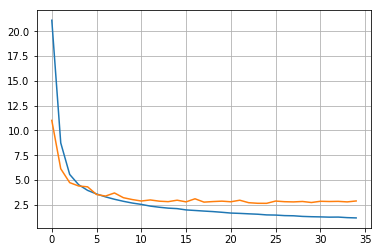

In [31]:
_ = plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.show()

In [32]:
# test NB_TEST_SAMPLES samples
res = model.predict(X_test[0:NB_TEST_SAMPLES])
print('res.shape:', res.shape)
s = K.ctc_decode(y_pred=res, input_length=input_length[0:res.shape[0]], greedy=True)
#print(s)

n_tested = 0
n_ok = 0
n_ko = 0
results = np.asarray(s[0][0])

#print('results.shape:', results.shape)

targets = []
predictions = []

df_results = pd.DataFrame(columns=['Mot', 'Prononciation_Wiktionnaire', 'Prononciation_Prédite', 'Résultat'])
for i in range(NB_TEST_SAMPLES):
    phonemes = ''
    mot = get_string_from_numpy(mots_test[i])
    prononciation = get_string_from_numpy(prononciations_test[i])
    prediction_res = True
    
    for letter in range(results.shape[1]):
        val = results[i, letter]
        if val == -1:
            continue
        phoneme = int_2_char[val+1]
        #print('r=',results[n,letter],end=',')
        phonemes += phoneme
    phonemes = phonemes.replace("\'",'')
    targets.append(prononciation)
    predictions.append(phonemes)
    n_tested += 1
    if phonemes == prononciation:
        n_ok += 1
    else:
        n_ko += 1
        prediction_res = False
    df_results = df_results.append({'Mot': mot, 
                                    'Prononciation_Wiktionnaire': prononciation, 
                                    'Prononciation_Prédite': phonemes, 
                                    'Résultat': prediction_res}, 
                                   ignore_index=True)
        
print('n_tested:%d, n_ok:%d, n_ko:%d' % (n_tested, n_ok, n_ko))
print()
print('Prediction results: %d%% ok and %d%% ko (out of %d samples tested)' % \
      (round(n_ok/n_tested*100), round(n_ko/n_tested*100), n_tested))

res.shape: (1000, 87, 40)
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
n_tested:1000, n_ok:604, n_ko:396

Prediction results: 60% ok and 40% ko (out of 1000 samples tested)


In [33]:
df_results.sample(10)

,Mot,Prononciation_Wiktionnaire,Prononciation_Prédite,Résultat
818,passagèrement,pasaʒɛʁmɑ̃,pasaʒɛʁmɑ̃,True
970,tortue,tɔʁty,tɔʁtys,False
13,LPT,ɛlpete,ɛlpete,True
200,galeuse,ɡaløz,ɡaløz,True
694,volontariste,vɔlɔ̃taʁist,vɔlɔ̃taʁist,True
99,exécution,eɡzekysjɔ̃,ɛɡzekysjɔ̃,False
951,anti-européisme,ɑ̃tiøʁɔpeism,ɑ̃tøʁɔpeism,False
662,principiellement,pʁɛ̃sipjɛlmɑ̃,pʁɛ̃sikjiɛlmɑ̃,False
584,manger du lotus,mɑ̃ʒedylɔtys,mɑ̃ʒødylɔtys,False
826,moyennement,mwajɛnmɑ̃,mwajɛnmɑ̃,True


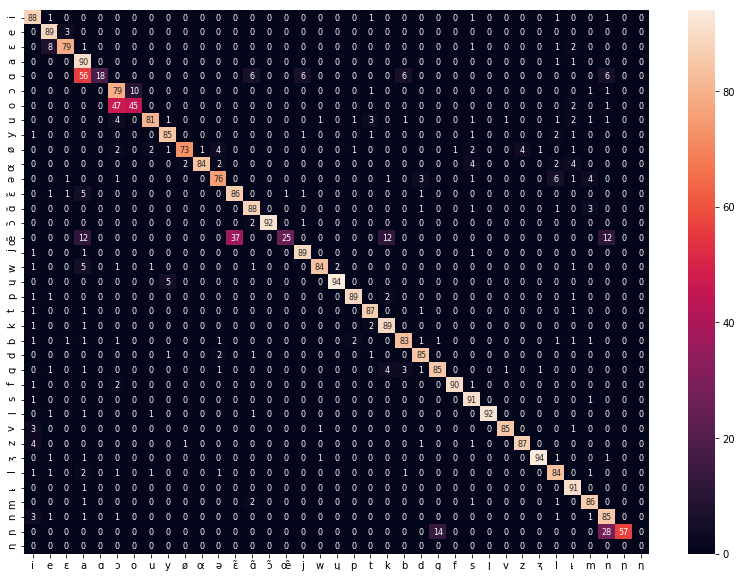

In [34]:
# create a copy of char_2_int without \' and <SPACE>
char_2_int2 = char_2_int.copy()
del char_2_int2["'"]
del char_2_int2["<SPACE>"]

counting_bad_cases = Counter({})
n_bad_letters = 0

# fill a confusion matrix 
confusion_array = np.zeros((len(char_2_int),len(char_2_int)))
for i in range(len(targets)):
    target_phonemes = get_phonemes(targets[i])
    prediction_phonemes = get_phonemes(predictions[i])
    for j in range(len(target_phonemes)):
        letter_targeted = target_phonemes[j]
        if j < len(prediction_phonemes):
            letter_predicted = prediction_phonemes[j]
            letter_targeted_index = char_2_int[letter_targeted]
            letter_predicted_index = char_2_int[letter_predicted]
            try:
                confusion_array[letter_targeted_index, letter_predicted_index] += 1
            except:
                print('error target letter:%s (%s), prediction:%s, predicted letter (in %s)' %\
                (letter_targeted, targets[i], letter_predicted, predictions[i]))
            if letter_predicted != letter_targeted : 
                key = letter_predicted + '-' + letter_targeted
                counting_bad_cases[key] += 1
                n_bad_letters += 1
                
for t in range(confusion_array.shape[0]):
    sum = 0
    for p in range(confusion_array.shape[1]):
        sum += confusion_array[t, p]
    for p in range(confusion_array.shape[1]):
        if sum > 0:
            confusion_array[t, p] = int(confusion_array[t, p]/sum*100)
            
# display the confusion matrix
# create a copy of char map without first two chars (' and SPACE)
char_2_int2 = char_2_int.copy()
del char_2_int2["'"]
del char_2_int2["<SPACE>"]
# display the confusion matrix without first 2 rows and first 2 colums
df_cm = pd.DataFrame(confusion_array[2:,2:], index = [i for i in char_2_int2],
                  columns = [i for i in char_2_int2])
_ = plt.figure(figsize = (14,10))
_ = sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, fmt='g')
_ = plt.show()

In [35]:
_counting_bad_cases = Counter({})

for key in counting_bad_cases.keys():
    _counting_bad_cases[key] = int(counting_bad_cases[key]/n_bad_letters*10000)/100

print("percentage of the 10 top_most errors:")
print('')
print("[(predicted_phoneme-target_phoneme), percentage]")
_counting_bad_cases.most_common(10)

percentage of the 10 top_most errors:

[(predicted_phoneme-target_phoneme), percentage]


[('ɔ-o', 5.26),
 ('o-ɔ', 2.72),
 ('e-ɛ', 2.08),
 ('ɛ-e', 1.72),
 ('ʁ-a', 0.99),
 ('l-ə', 0.9),
 ('a-ʁ', 0.9),
 ('a-ɑ', 0.81),
 ('a-l', 0.81),
 ('i-s', 0.81)]

In [36]:
df_results[df_results.Résultat == False]\
[df_results.Prononciation_Prédite.str.contains('ɔ')]\
[df_results.Prononciation_Wiktionnaire.str.contains('o')].sample(5)

/home/xavier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/xavier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,Mot,Prononciation_Wiktionnaire,Prononciation_Prédite,Résultat
765,se vautrer,səvotʁe,səvɔtʁe,False
237,co-naitre,konɛtʁ,kɔnɛtʁ,False
638,homozygote,omoziɡɔt,ɔmoziɡɔt,False
782,trichophobie,tʁikofobi,fʁikɔfɔbi,False
428,zonation,zonasjɔ̃,zɔnasjɔ̃,False
